## Problem definition

Our objective is to use reinforcement learning to learn a policy of routes for a trash collector truck. An optimized oath can help in obtaining a faster and more efficient trash collection. The problem can be modeled as identifying a path inside a graph. This problem have been previously solved using other optimization approachs, heuristics and graph algorithms, however we want to apply reinforcement learning in it for educational purposes and compare it with other approaches. The problem can be defined as follow:

**Def. 1**: With a weighted directed graph $G = (V, E)$, and a starting node $v$, find the shortest path to node $u$.

**Def. 2**: With a weighted directed graph $G = (V, E)$, and a set of nodes $U = \{u_1, \dots, u_k\}$, find the shortest path that traverse all nodes.

The second definition is a harder problem in which the model has to learn the best order of collection. The problem can be modeled in the reinforcement learning format as follow:

**Reinforcement learning model**:
- Episodic, finishes when arrive on destination node.
- States: $n$ states $v_i \in V$ , each is a node of the graph.
- Actions: $n$ action, each one correspond to moving to a specific node. It is important to note that the action to move to node $u$, if the state is node $v$, can only be made if there is an edge from $v$ to $u$.
- Reward will be $0$ at any node and will be $1$ if the node is the desired one (or one of the set of desired nodes). Impossible actions (moving trought a non-existent edge) will have reward equal to -1.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.append('src/')

import simulation
import models

%load_ext autoreload
%autoreload 2

In [24]:
n_nodes = 500
G = nx.barabasi_albert_graph(n_nodes, 1)
# if there is an edge between 0 and 99, remove it
if G.has_edge(0, n_nodes - 1):
    G.remove_edge(0, n_nodes - 1)
# add random weights to edges
for edge in G.edges():
    G.edges[edge]["weight"] = np.random.random()
print("Path between first and last node:", nx.shortest_path(G, 0, n_nodes - 1))
# print weight of the shortest path
print("Weight of the shortest path:", nx.shortest_path_length(G, 0, n_nodes - 1, weight = "weight"))

if n_nodes < 200:
    nx.draw(G)

Path between first and last node: [0, 145, 156, 355, 431, 499]
Weight of the shortest path: 0.9829719085983479


Path between first and last node: [0, 184, 180, 210, 309, 86, 85, 82, 80, 79, 78, 77, 95, 40, 39, 342]
Weight of the shortest path: 12.248062015503878


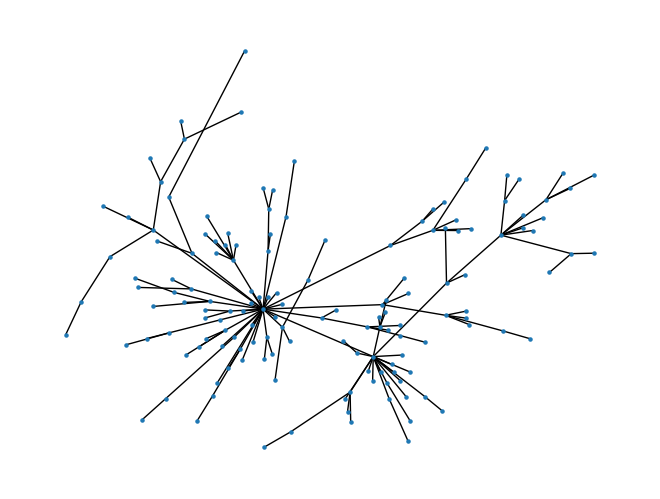

In [18]:
G_city = np.load("data/adjacency_matrix.npy")
G_city = nx.from_numpy_array(G_city, create_using=nx.DiGraph)
# get max weight and make weights range from 0 to 10
max_weight = 0
for edge in G_city.edges():
    if G_city.edges[edge]["weight"] > max_weight:
        max_weight = G_city.edges[edge]["weight"]
for edge in G_city.edges():
    G_city.edges[edge]["weight"] = G_city.edges[edge]["weight"] / max_weight * 10

n_nodes = len(G_city.nodes)
print("Path between first and last node:", nx.shortest_path(G_city, 0, n_nodes - 1))
print("Weight of the shortest path:", nx.shortest_path_length(G_city, 0, n_nodes - 1, weight = "weight"))

nx.draw(G, pos=nx.spring_layout(G), node_size = 5)


### Q-learning solution

https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial

https://www.deeplearningbook.com.br/algoritmo-de-agente-baseado-em-ia-com-reinforcement-learning-q-learning/


$$Q^{\pi} (s_t, a_t) = \mathbb{E} \left[ R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3}+ \dots | s_t, a_t\right]$$

$$Q (s_t, a_t) \leftarrow Q (s_t, a_t) + \delta \left[ R_{t+1} + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t)\right] $$

### Deterministic

In [64]:
env = simulation.Environment(G, n_nodes - 1, reward = "unit")

In [65]:
learning_rate_values = [0.1, 0.3, 0.5, 0.7, 0.9]
mean_reward = []
std_reward = []
for learning_rate in learning_rate_values:
    Q = models.Q_learning(env, learning_rate = learning_rate, n_episodes=10000)
    Q.train()
    e, sd = Q.evaluate_agg()
    mean_reward.append(e)
    std_reward.append(sd)

In [67]:
mean_reward

[0.0, 0.0, 0.0, 0.0, 0.0]

<ErrorbarContainer object of 3 artists>

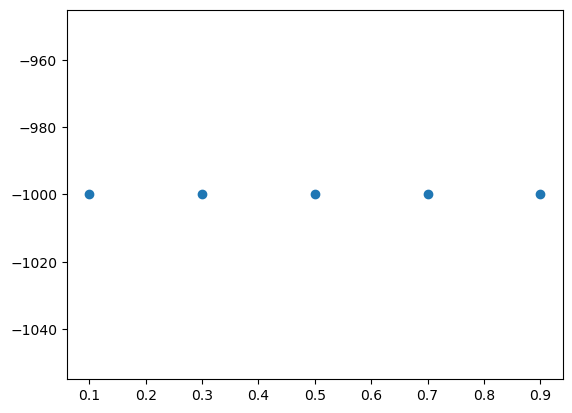

In [50]:
plt.errorbar(learning_rate_values, mean_reward, yerr=std_reward, fmt='o')

### Sthocastic

In [15]:
env = simulation.Environment(G, n_nodes - 1, mode = "stochastic")

[0, 1, 9, 13, 149]


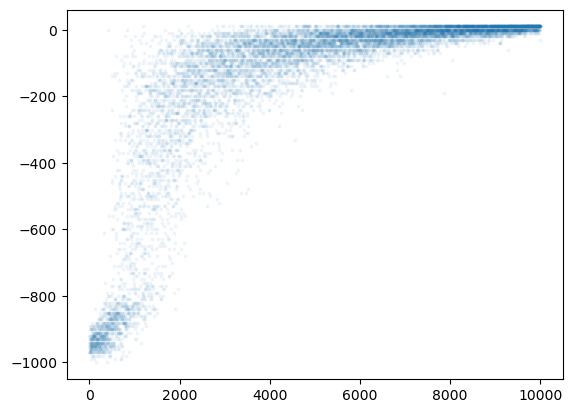

In [16]:
Q = models.Q_learning(env, n_episodes = 10000)
Q.train()
print(Q.evaluate(0))
plt.scatter(list(range(Q.n_episodes)), Q.episode_rewards, alpha = 0.05, s = 3)
plt.show()

### Testing with other graph

[]


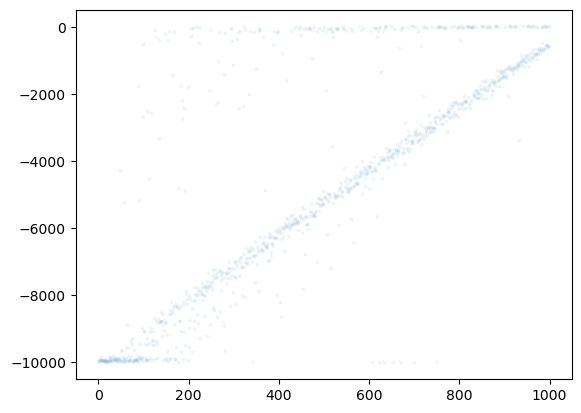

In [22]:
env = simulation.Environment(G_city, n_nodes - 1)
Q = models.Q_learning(env, n_episodes = 1000, max_steps = 1000)
Q.train()
print(Q.evaluate(0))
plt.scatter(list(range(Q.n_episodes)), Q.episode_rewards, alpha = 0.05, s = 3)
plt.show()

[]


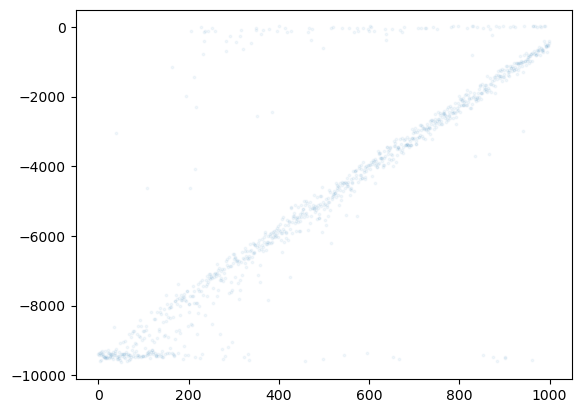

In [21]:
env = simulation.Environment(G_city, n_nodes - 1, mode = "stochastic")
Q = models.Q_learning(env, n_episodes = 1000, max_steps = 1000)
Q.train()
print(Q.evaluate(0))
plt.scatter(list(range(Q.n_episodes)), Q.episode_rewards, alpha = 0.05, s = 3)
plt.show()